In [1]:
import numpy as np
import itertools
import collections
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix

In [2]:
file_name = "0_2021-02-22_2021-02-28.csv"

In [3]:
week = 0
df = pd.read_csv(file_name)
df.drop(df.columns[0], axis = 1, inplace= True)
df.rename(columns = {"0":"page", "1":"user"}, inplace=True)
df.dropna(axis = 0, inplace=True)
df.head()

,page,user
0,2812961,1367572112
1,2812961,1220374182330015744
2,2812961,593858001
3,2812961,793367160341094400
4,2812961,1135103330357796864


In [4]:
mapping_pages = {user:index for index, user in enumerate(set(df["page"]))}
mapping_users = {page:index for index, page in enumerate(set(df["user"]))}
rev_dict_pages = {value:key for key,value in mapping_pages.items()}
rev_dict_users = {value:key for key,value in mapping_users.items()}

In [5]:
df_ = pd.DataFrame()
df_["page"] = df["page"].replace(mapping_pages)
df_["user"] = df["user"].replace(mapping_users)

In [6]:
a_ = df_.loc[1:2,]
a_

,page,user
1,833,11628
2,833,20898


In [7]:
c_ = df_.loc[77344,]
c_ = pd.DataFrame(c_).T
c_

,page,user
77344,550,11628


In [8]:
d_ = df_[df_["page"] == 874]

In [9]:
e_ = df_[df_["page"] == 2133]

In [10]:
f_ = d_.merge(e_, on="user")
f_

,page_x,user,page_y
0,874,26332,2133
1,874,17383,2133
2,874,20142,2133
3,874,20435,2133


In [11]:
f_.drop(2, inplace=True)

In [12]:
g_ = f_[["page_y", "user"]].rename({"page_y" : "page"}, axis = 1)
g_

,page,user
0,2133,26332
1,2133,17383
3,2133,20435


In [13]:
h_ = f_[["page_x", "user"]].rename({"page_x" : "page"}, axis = 1)
h_

,page,user
0,874,26332
1,874,17383
3,874,20435


In [14]:
viz = pd.concat([a_, c_, g_, h_])
viz

,page,user
1,833,11628
2,833,20898
77344,550,11628
0,2133,26332
1,2133,17383
3,2133,20435
0,874,26332
1,874,17383
3,874,20435


In [15]:
mapping_pages_ = {user:index for index, user in enumerate(set(viz["page"]))}
mapping_users_ = {page:index for index, page in enumerate(set(viz["user"]))}
rev_dict_pages_ = {value:key for key,value in mapping_pages.items()}
rev_dict_users_ = {value:key for key,value in mapping_users.items()}

In [16]:
viz_ = pd.DataFrame()
viz_["page"] = viz["page"].replace(mapping_pages_)
viz_["user"] = viz["user"].replace(mapping_users_)

In [17]:
viz_.reset_index(inplace=True)
del viz_["index"]
viz_

,page,user
0,0,2
1,0,0
2,3,2
3,2,4
4,2,1
5,2,3
6,1,4
7,1,1
8,1,3


In [18]:
viz_ = viz_.append(pd.DataFrame({"page" : 3, "user" : 4}, index = [9]))
viz_ = viz_.append(pd.DataFrame({"page" : 3, "user" : 0}, index = [10]))

In [19]:
from IPython.display import SVG
from sknetwork.visualization import svg_graph, svg_bigraph
from sknetwork.utils import edgelist2biadjacency

In [20]:
bi_adj_graph = edgelist2biadjacency([tuple(x) for x in list(viz_.to_numpy())])
bi_adj_graph

<4x5 sparse matrix of type '<class 'numpy.bool_'>'
	with 11 stored elements in Compressed Sparse Row format>

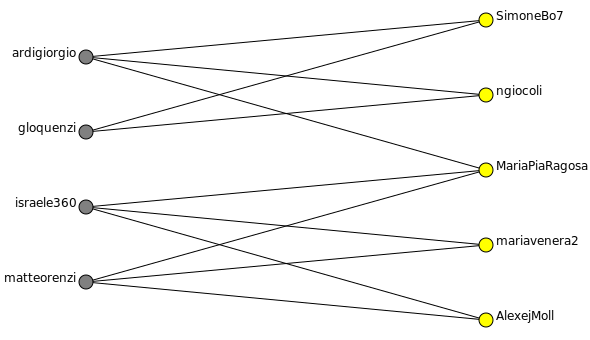

In [21]:
image = svg_bigraph(bi_adj_graph, names_row = ["gloquenzi", "matteorenzi", "israele360", "ardigiorgio"], names_col=["ngiocoli", "AlexejMoll", "SimoneBo7", "mariavenera2", "MariaPiaRagosa"], color_row='gray', color_col='yellow')
SVG(image)

In [22]:
indexes = viz_[["user", "page"]].to_numpy()
indexes

array([[2, 0],
       [0, 0],
       [2, 3],
       [4, 2],
       [1, 2],
       [3, 2],
       [4, 1],
       [1, 1],
       [3, 1],
       [4, 3],
       [0, 3]], dtype=int64)

In [23]:
user_pages_dict = collections.defaultdict(list)
for tuple_ in indexes:
    if tuple_[1] not in user_pages_dict[tuple_[0]]:
        user_pages_dict[tuple_[0]].append(tuple_[1])

edges = [pages_index_pair for pages_index in user_pages_dict.values() if len(pages_index) > 1 for pages_index_pair in list(itertools.permutations(pages_index, 2))]
edges_weights = collections.Counter(edges)
edges_weights

Counter({(0, 3): 2,
         (3, 0): 2,
         (2, 1): 3,
         (2, 3): 1,
         (1, 2): 3,
         (1, 3): 1,
         (3, 2): 1,
         (3, 1): 1})

In [24]:
def dict_to_sparse_matrix(dict_graph):
    data = np.array(list(dict_graph.values()))
    A = np.array(list(dict_graph.keys()))
    rows = A.T[1]
    cols = A.T[0]
    B = coo_matrix((data, (rows, cols)), shape=(len(mapping_pages_), len(mapping_pages_)))
    return csr_matrix(B)

In [25]:
P = dict_to_sparse_matrix(edges_weights)
print(P)

  (0, 3)	2
  (1, 2)	3
  (1, 3)	1
  (2, 1)	3
  (2, 3)	1
  (3, 0)	2
  (3, 1)	1
  (3, 2)	1


In [26]:
from sknetwork.clustering import Louvain, PropagationClustering, modularity 
louvain = Louvain(modularity="dugue")
labels_louvain = louvain.fit_transform(P)

In [27]:
labels_louvain

array([1, 0, 0, 1], dtype=int64)

In [28]:
from sknetwork.data import karate_club, painters, movie_actor, load_netset
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

In [29]:
position = np.array([[ 0.6,  0.2],
       [ 0.20, 0],
       [ 0.20,  0.4],
       [ 0.4, 0.2]])


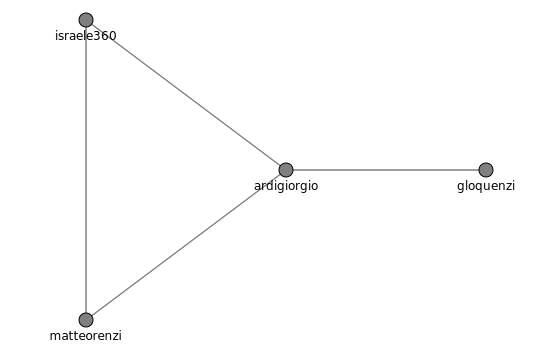

In [30]:
image = svg_graph(P, names=["gloquenzi", "matteorenzi", "israele360", "ardigiorgio"], position = position, name_position='below', display_edge_weight = False, node_color = "gray")
SVG(image)

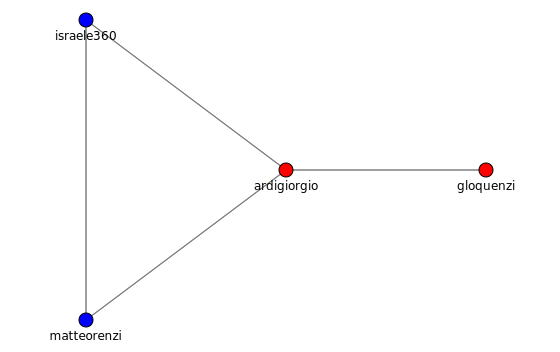

In [31]:
image = svg_graph(P, names=["gloquenzi", "matteorenzi", "israele360", "ardigiorgio"], position = position, name_position='below', labels=labels_louvain, display_edge_weight = False)
SVG(image)

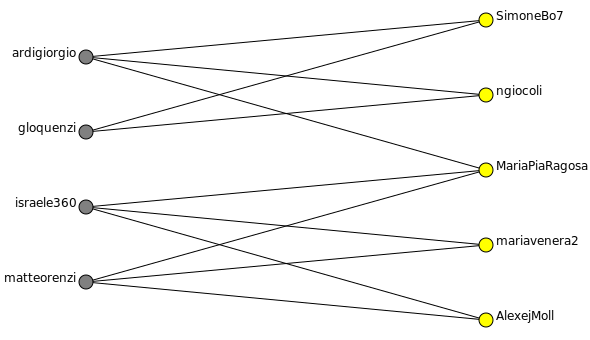

In [32]:
image = svg_bigraph(bi_adj_graph, names_row = ["gloquenzi", "matteorenzi", "israele360", "ardigiorgio"], names_col=["ngiocoli", "AlexejMoll", "SimoneBo7", "mariavenera2", "MariaPiaRagosa"], color_row='gray', color_col='yellow')
SVG(image)